# NeRF assignment
Paper link: https://arxiv.org/abs/2003.08934

Download data using the commands shown below.

In [1]:
!wget https://fashion-simulation.s3.amazonaws.com/assignment/nerf_datasets/testing_data.pkl
!wget https://fashion-simulation.s3.amazonaws.com/assignment/nerf_datasets/training_data.pkl

--2025-05-01 23:44:59--  https://fashion-simulation.s3.amazonaws.com/assignment/nerf_datasets/testing_data.pkl
Resolving fashion-simulation.s3.amazonaws.com (fashion-simulation.s3.amazonaws.com)... 52.216.248.204, 52.216.178.99, 54.231.226.121, ...
Connecting to fashion-simulation.s3.amazonaws.com (fashion-simulation.s3.amazonaws.com)|52.216.248.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1152000164 (1.1G) [binary/octet-stream]
Saving to: ‘testing_data.pkl’

testing_data.pkl    100%[===================>]   1.07G  2.99MB/s    in 6m 25s  

2025-05-01 23:51:31 (2.85 MB/s) - ‘testing_data.pkl’ saved [1152000164/1152000164]

--2025-05-01 23:51:31--  https://fashion-simulation.s3.amazonaws.com/assignment/nerf_datasets/training_data.pkl
Resolving fashion-simulation.s3.amazonaws.com (fashion-simulation.s3.amazonaws.com)... 52.217.173.161, 52.216.215.9, 52.217.163.49, ...
Connecting to fashion-simulation.s3.amazonaws.com (fashion-simulation.s3.amazonaws.com)|52

In [10]:
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [11]:
device = 'mps'

In [12]:
class NerfModel(nn.Module):
    def __init__(self, embedding_dim_pos=6, embedding_dim_direction=4, hidden_dim=128):
        super(NerfModel, self).__init__()

        input_dim_block1 = embedding_dim_pos * 6 + 3
        layer_activation = nn.ReLU()

        self.block1 = nn.Sequential(nn.Linear(input_dim_block1, hidden_dim),
                                    nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim),
                                    nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim),
                                    nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim),
                                    nn.ReLU())

        # density estimation
        input_dim_block2 = embedding_dim_pos * 6 + hidden_dim + 3

        self.block2 = nn.Sequential(nn.Linear(input_dim_block2, hidden_dim),
                                    nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim),
                                    nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim),
                                    nn.ReLU(),
                                    nn.Linear(hidden_dim, hidden_dim + 1))

        # color estimation
        self.block3 = nn.Sequential(nn.Linear(embedding_dim_direction * 6 + hidden_dim + 3, hidden_dim // 2), nn.ReLU(), )
        self.block4 = nn.Sequential(nn.Linear(hidden_dim // 2, 3), nn.Sigmoid(), )

        self.embedding_dim_pos = embedding_dim_pos
        self.embedding_dim_direction = embedding_dim_direction
        self.relu = nn.ReLU()

    @staticmethod
    def positional_encoding(x, L):
        out = [x]
        for j in range(L):
            out.append(torch.sin(2 ** j * x))
            out.append(torch.cos(2 ** j * x))
        return torch.cat(out, dim=1)

    def forward(self, o, d):
        emb_x = self.positional_encoding(o, self.embedding_dim_pos) # emb_x: [batch_size, embedding_dim_pos * 6 + 3]
        emb_d = self.positional_encoding(d, self.embedding_dim_direction) # emb_d: [batch_size, embedding_dim_direction * 6 + 3]
        h = self.block1(emb_x) # h: [batch_size, hidden_dim]
        tmp = self.block2(torch.cat((h, emb_x), dim=1)) # tmp: [batch_size, hidden_dim + 1]
        h, sigma = tmp[:, :-1], self.relu(tmp[:, -1]) # h: [batch_size, hidden_dim], sigma: [batch_size]
        h = self.block3(torch.cat((h, emb_d), dim=1)) # h: [batch_size, hidden_dim // 2]
        c = self.block4(h) # c: [batch_size, 3]
        return c, sigma

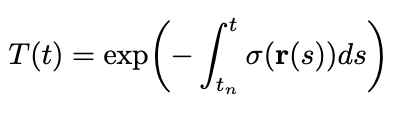

In [13]:
def compute_accumulated_transmittance(alphas):
    accumulated_transmittance = torch.cumprod(alphas, dim=1)
    return torch.cat((torch.ones((accumulated_transmittance.shape[0], 1), device=alphas.device),
                      accumulated_transmittance[:, :-1]), dim=-1)

In [14]:
def render_rays(nerf_model, ray_origins, ray_directions, hn=0, hf=0.5, nb_bins=192):
    device = ray_origins.device


    t = torch.linspace(hn, hf, nb_bins).unsqueeze(dim=0).to(device)
    # print(f"t; {t.unsqueeze(2).shape} || ray_origins.unsqueeze(1): {ray_origins.unsqueeze(1).shape} || ray_directions.unsqueeze(1): {ray_directions.unsqueeze(1).shape}")
    # Compute the 3D points along each ray
    x = ray_origins.unsqueeze(1) + t.unsqueeze(2) * ray_directions.unsqueeze(1)   # [batch_size, nb_bins, 3]

    # Expand the ray_directions tensor to match the shape of x
    ray_directions = ray_directions.expand(nb_bins, ray_directions.shape[0], 3).transpose(0, 1)

    colors, sigma = nerf_model(x.reshape(-1, 3), ray_directions.reshape(-1, 3))
    colors = colors.reshape(x.shape)
    sigma = sigma.reshape(x.shape[:-1])

    transmittance_all = torch.exp(-sigma*(hf-hn)/nb_bins)

    alpha = 1 - transmittance_all  # [batch_size, nb_bins]
    weights = compute_accumulated_transmittance(1 - alpha).unsqueeze(2) * alpha.unsqueeze(2)
    # Compute the pixel values as a weighted sum of colors along each ray
    c = (weights * colors).sum(dim=1)
    weight_sum = weights.sum(-1).sum(-1)  # Regularization for white background
    return c + 1 - weight_sum.unsqueeze(-1)

In [15]:
@torch.no_grad()
def test(hn, hf, dataset, chunk_size=10, img_index=0, nb_bins=192, H=400, W=400):
    """
    Args:
        hn: near plane distance
        hf: far plane distance
        dataset: dataset to render
        chunk_size (int, optional): chunk size for memory efficiency. Defaults to 10.
        img_index (int, optional): image index to render. Defaults to 0.
        nb_bins (int, optional): number of bins for density estimation. Defaults to 192.
        H (int, optional): image height. Defaults to 400.
        W (int, optional): image width. Defaults to 400.

    Returns:
        None: None
    """
    ray_origins = dataset[img_index * H * W: (img_index + 1) * H * W, :3]
    ray_directions = dataset[img_index * H * W: (img_index + 1) * H * W, 3:6]

    data = []   # list of regenerated pixel values
    for i in range(int(np.ceil(H / chunk_size))):   # iterate over chunks
        # Get chunk of rays
        ray_origins_ = ray_origins[W*chunk_size*i:W*chunk_size*(i+1)].to(device)
        ray_directions_ = ray_directions[W*chunk_size*i:W*chunk_size*(i+1)].to(device)

        regenerated_px_values = render_rays(model, ray_origins_, ray_directions_, hn=hn, hf=hf, nb_bins=nb_bins)
        data.append(regenerated_px_values)
    img = torch.cat(data).data.cpu().numpy().reshape(H, W, 3)

    plt.figure()
    plt.imshow(img)

In [16]:
def train(nerf_model, optimizer, scheduler, data_loader, testing_dataset, device='cpu', hn=0, hf=1, nb_epochs=int(1e5),
          nb_bins=192, H=400, W=400):
    training_loss = []
    for _ in tqdm(range(nb_epochs)):
        for batch in data_loader:
            ray_origins = batch[:, :3].to(device)
            ray_directions = batch[:, 3:6].to(device)
            ground_truth_px_values = batch[:, 6:].to(device)

            regenerated_px_values = render_rays(nerf_model, ray_origins, ray_directions, hn=hn, hf=hf, nb_bins=nb_bins)
            loss = ((ground_truth_px_values - regenerated_px_values) ** 2).sum()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            training_loss.append(loss.item())
        scheduler.step()

        # for img_index in range(100):
        test(hn, hf, testing_dataset, img_index=0, nb_bins=nb_bins, H=H, W=W)
    return training_loss

100%|██████████| 1/1 [01:13<00:00, 73.86s/it]


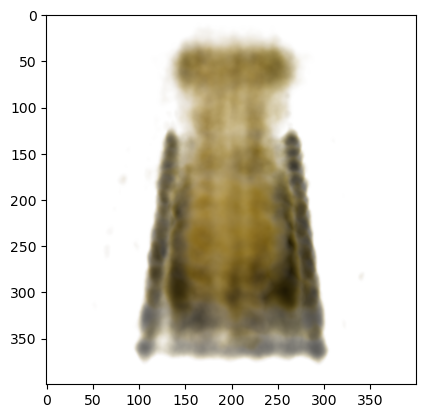

In [17]:
training_dataset = torch.from_numpy(np.load('training_data.pkl', allow_pickle=True))
downscaled_data = training_dataset.reshape([100, 400, 400, 9])[..., ::4, ::4, 0:9].flatten(end_dim=-2)
testing_dataset = torch.from_numpy(np.load('testing_data.pkl', allow_pickle=True))
model = NerfModel(hidden_dim=256).to(device)
model_optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(model_optimizer, milestones=[2, 4, 8], gamma=0.5)
data_loader = DataLoader(downscaled_data, batch_size=8*1024, shuffle=True)
print(f" ")
loss = train(model, model_optimizer, scheduler, data_loader, testing_dataset, nb_epochs=1, device=device, hn=2, hf=6, nb_bins=32, H=400, W=400)